In [57]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

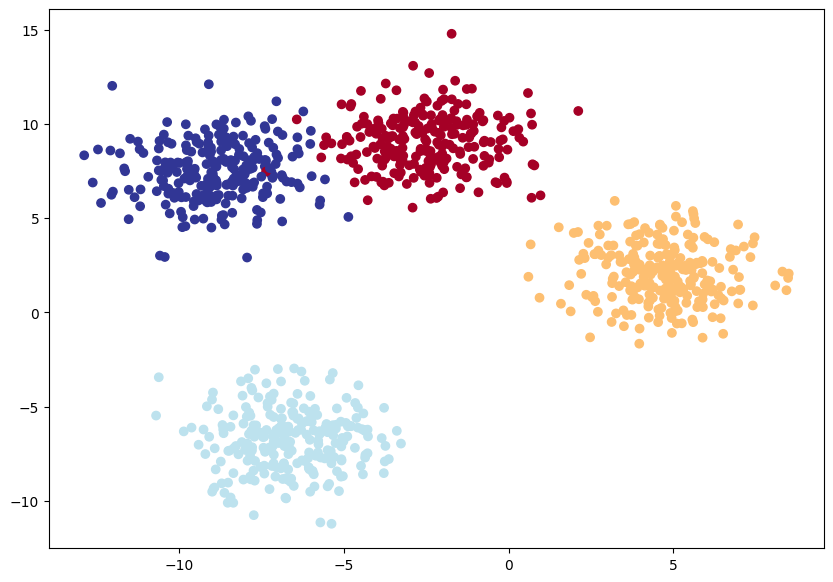

In [71]:
num_classes = 4
num_features = 2
random_seed = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5, # give the clusters a little snake up
                            random_state=random_seed
                            )

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=random_seed)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [60]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8)

model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [61]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [62]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [64]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [65]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [66]:
# in order to evaluate and train and test our model, we need to convert our model's outputs(logtis) to predicition probabilities and then to prediction labels.

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


tensor([1, 0, 0, 0, 0])

In [67]:
from helper_functions import accuracy_fn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.4f}, acc: {acc:.2f} | test_loss{test_loss:.4f}, test_acc: {test_acc:.2f}")


epoch: 0 | loss: 1.1588, acc: 40.38 | test_loss1.0755, test_acc: 48.00
epoch: 10 | loss: 0.6448, acc: 96.75 | test_loss0.6607, test_acc: 97.50
epoch: 20 | loss: 0.4254, acc: 98.50 | test_loss0.4307, test_acc: 100.00
epoch: 30 | loss: 0.2529, acc: 99.12 | test_loss0.2451, test_acc: 99.50
epoch: 40 | loss: 0.1123, acc: 99.25 | test_loss0.1023, test_acc: 99.50
epoch: 50 | loss: 0.0663, acc: 99.25 | test_loss0.0585, test_acc: 99.50
epoch: 60 | loss: 0.0507, acc: 99.25 | test_loss0.0429, test_acc: 99.50
epoch: 70 | loss: 0.0430, acc: 99.25 | test_loss0.0349, test_acc: 99.50
epoch: 80 | loss: 0.0384, acc: 99.25 | test_loss0.0299, test_acc: 99.50
epoch: 90 | loss: 0.0352, acc: 99.25 | test_loss0.0266, test_acc: 99.50


In [68]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [69]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:

        f.write(request.content)

helper_functions.py already exists, skipping download


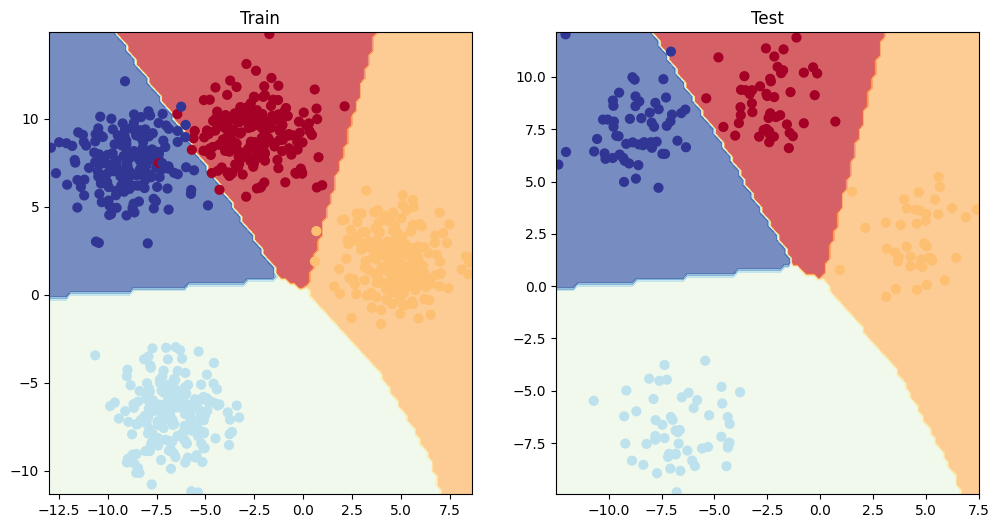

In [70]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    """定义二元函数 f(x, y) = x² + xy + y²"""
    return x**2 + x*y + y**2

def plot_function():
    # 设置绘图风格
    plt.style.use('seaborn-v0_8')
    
    # 创建图形和子图
    fig = plt.figure(figsize=(16, 6))
    
    # 1. 3D曲面图
    ax1 = fig.add_subplot(121, projection='3d')
    
    # 生成数据点
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # 绘制3D曲面
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, 
                       rstride=2, cstride=2, linewidth=0.1)
    
    # 设置3D图标签和标题
    ax1.set_xlabel('X轴', fontsize=12, labelpad=10)
    ax1.set_ylabel('Y轴', fontsize=12, labelpad=10)
    ax1.set_zlabel('Z轴', fontsize=12, labelpad=10)
    ax1.set_title('3D曲面图: f(x,y) = x² + xy + y²', fontsize=14, pad=20)
    
    # 添加颜色条
    fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=20)
    
    # 2. 等高线图
    ax2 = fig.add_subplot(122)
    
    # 绘制等高线
    contour = ax2.contour(X, Y, Z, levels=15, colors='black', alpha=0.6)
    ax2.clabel(contour, inline=True, fontsize=8)
    
    # 填充等高线
    contourf = ax2.contourf(X, Y, Z, levels=50, cmap='plasma', alpha=0.8)
    
    # 设置等高线图标签和标题
    ax2.set_xlabel('X轴', fontsize=12)
    ax2.set_ylabel('Y轴', fontsize=12)
    ax2.set_title('等高线图: f(x,y) = x² + xy + y²', fontsize=14, pad=20)
    
    # 添加颜色条
    fig.colorbar(contourf, ax=ax2, shrink=0.9)
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()

def analyze_function():
    """分析函数特性"""
    print("函数分析:")
    print("f(x, y) = x² + xy + y²")
    print("\n函数特性:")
    print("1. 这是一个正定二次型")
    print("2. 最小值在原点 (0,0)，f(0,0) = 0")
    print("3. 函数在任意方向都是凸的")
    print("4. 等高线是椭圆")
    
    # 计算一些特殊点的值
    points = [(0,0), (1,0), (0,1), (1,1), (-1,1)]
    print("\n特殊点函数值:")
    for point in points:
        x, y = point
        value = f(x, y)
        print(f"f({x},{y}) = {value}")



H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from font(s) Arial.
  plt.tight_layout()
H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) Arial.
  plt.tight_layout()
H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) Arial.
  plt.tight_layout()
H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) Arial.
  plt.tight_layout()
H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) Arial.
  plt.tight_layout()
H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) Arial.
  plt.tight_layout()
H:\Temp\ipykernel_6008\2340055711.py:57: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from 

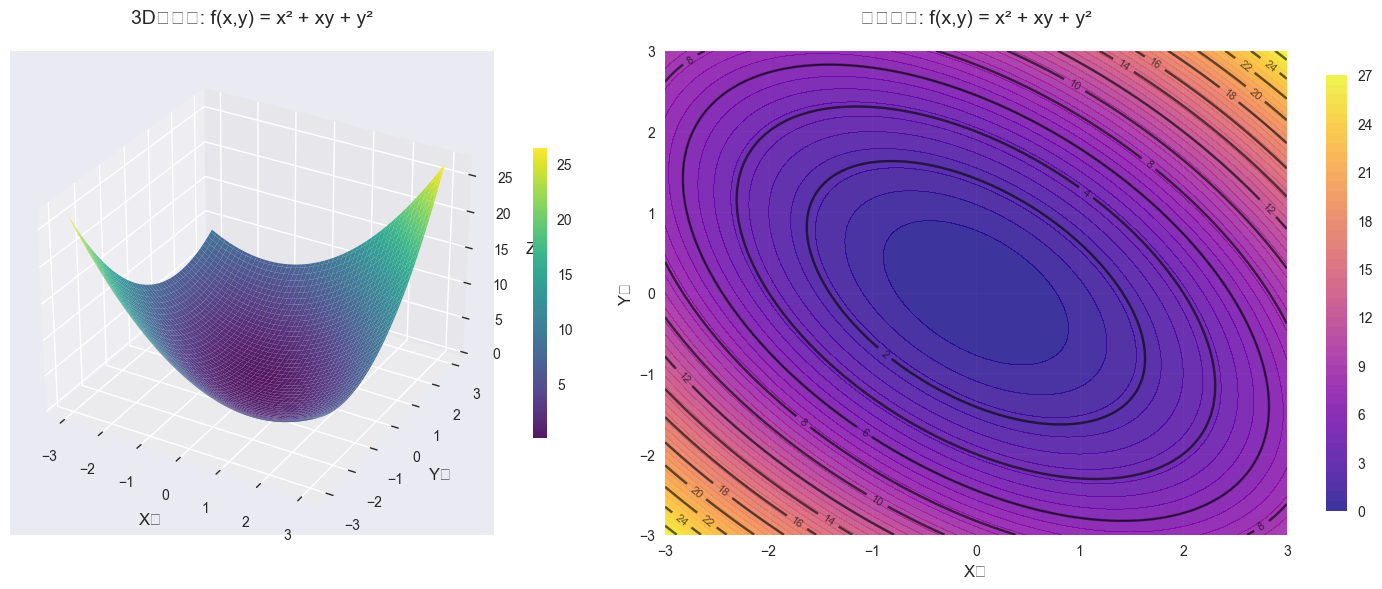

In [3]:
plot_function()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    """定义二元函数 f(x, y) = x² + xy + y²"""
    return x**2 + x*y + y**2

def gradient_f(x, y):
    """计算函数在(x,y)处的梯度向量"""
    df_dx = 2*x + y  # ∂f/∂x
    df_dy = x + 2*y  # ∂f/∂y
    return df_dx, df_dy

def plot_gradient_field():
    """绘制梯度场可视化"""
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建数据网格
    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # 计算梯度场
    U, V = gradient_f(X, Y)
    
    # 创建图形
    fig = plt.figure(figsize=(18, 8))
    
    # 1. 3D曲面图与梯度场
    ax1 = fig.add_subplot(131, projection='3d')
    
    # 绘制3D曲面
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
    
    # 在XY平面上绘制梯度向量
    ax1.quiver(X, Y, np.zeros_like(Z), U, V, np.zeros_like(Z), 
                         color='red', length=0.3, normalize=True,
                         arrow_length_ratio=0.3, linewidth=1)
    
    # 标记点(1,1)及其梯度
    point_x, point_y = 1, 1
    point_z = f(point_x, point_y)
    grad_x, grad_y = gradient_f(point_x, point_y)
    
    # 绘制点(1,1)
    ax1.scatter([point_x], [point_y], [point_z], 
                   color='blue', s=100, marker='o')
    
    # 绘制梯度向量
    ax1.quiver(point_x, point_y, point_z, 
                   grad_x, grad_y, 0, 
                   color='yellow', length=0.5, linewidth=3,
                   arrow_length_ratio=0.2)
    
    ax1.set_xlabel('X轴')
    ax1.set_ylabel('Y轴')
    ax1.set_zlabel('f(x,y)')
    ax1.set_title('3D梯度场可视化')
    
    # 2. 二维梯度场图
    ax2 = fig.add_subplot(132)
    
    # 绘制等高线
    contour = ax2.contour(X, Y, Z, levels=15, colors='black', alpha=0.6)
    ax2.clabel(contour, inline=True, fontsize=8)
    
    # 绘制梯度向量场
    ax2.quiver(X, Y, U, V, color='red', scale=30, 
                         width=0.004, alpha=0.8)
    
    # 标记点(1,1)及其梯度
    ax2.scatter([point_x], [point_y], color='blue', s=100)
    ax2.quiver(point_x, point_y, grad_x, grad_y, 
                   color='yellow', scale=15, width=0.008)
    
    # 添加梯度向量标注
    ax2.annotate(f'梯度({grad_x:.1f}, {grad_y:.1f})',
                xy=(point_x, point_y), xytext=(point_x+0.5, point_y+0.5),
                arrowprops=dict(arrowstyle='->', color='blue'))
    
    ax2.set_xlabel('X轴')
    ax2.set_ylabel('Y轴')
    ax2.set_title('二维梯度场')
    ax2.grid(True, alpha=0.3)
    
    # 3. 热力图与梯度场结合
    ax3 = fig.add_subplot(133)
    
    # 绘制热力图
    im = ax3.imshow(Z, extent=[-3,3,-3,3], origin='lower', 
                   cmap='plasma', aspect='auto')
    
    # 绘制梯度向量（稀疏化以减少重叠）
    interval = 2
    X_sub = X[::interval, ::interval]
    Y_sub = Y[::interval, ::interval]
    U_sub = U[::interval, ::interval]
    V_sub = V[::interval, ::interval]
    
    ax3.quiver(X_sub, Y_sub, U_sub, V_sub, 
                   color='white', scale=25, width=0.005)
    
    # 标记点(1,1)
    ax3.scatter([point_x], [point_y], color='blue', s=100)
    
    ax3.set_xlabel('X轴')
    ax3.set_ylabel('Y轴')
    ax3.set_title('热力图梯度场')
    
    plt.tight_layout()
    plt.show()
    
    return grad_x, grad_y

def analyze_gradient_at_point(x, y):
    """分析在特定点的梯度"""
    grad_x, grad_y = gradient_f(x, y)
    func_value = f(x, y)
    
    print(f"\n在点 ({x}, {y}) 处的分析:")
    print(f"函数值 f({x}, {y}) = {func_value:.2f}")
    print(f"梯度向量 ∇f = ({grad_x:.2f}, {grad_y:.2f})")
    print(f"梯度大小 ||∇f|| = {np.sqrt(grad_x**2 + grad_y**2):.2f}")
    print(f"梯度方向: {np.arctan2(grad_y, grad_x) * 180/np.pi:.1f}°")

In [5]:
analyze_gradient_at_point(1, 1)



在点 (1, 1) 处的分析:
函数值 f(1, 1) = 3.00
梯度向量 ∇f = (3.00, 3.00)
梯度大小 ||∇f|| = 4.24
梯度方向: 45.0°


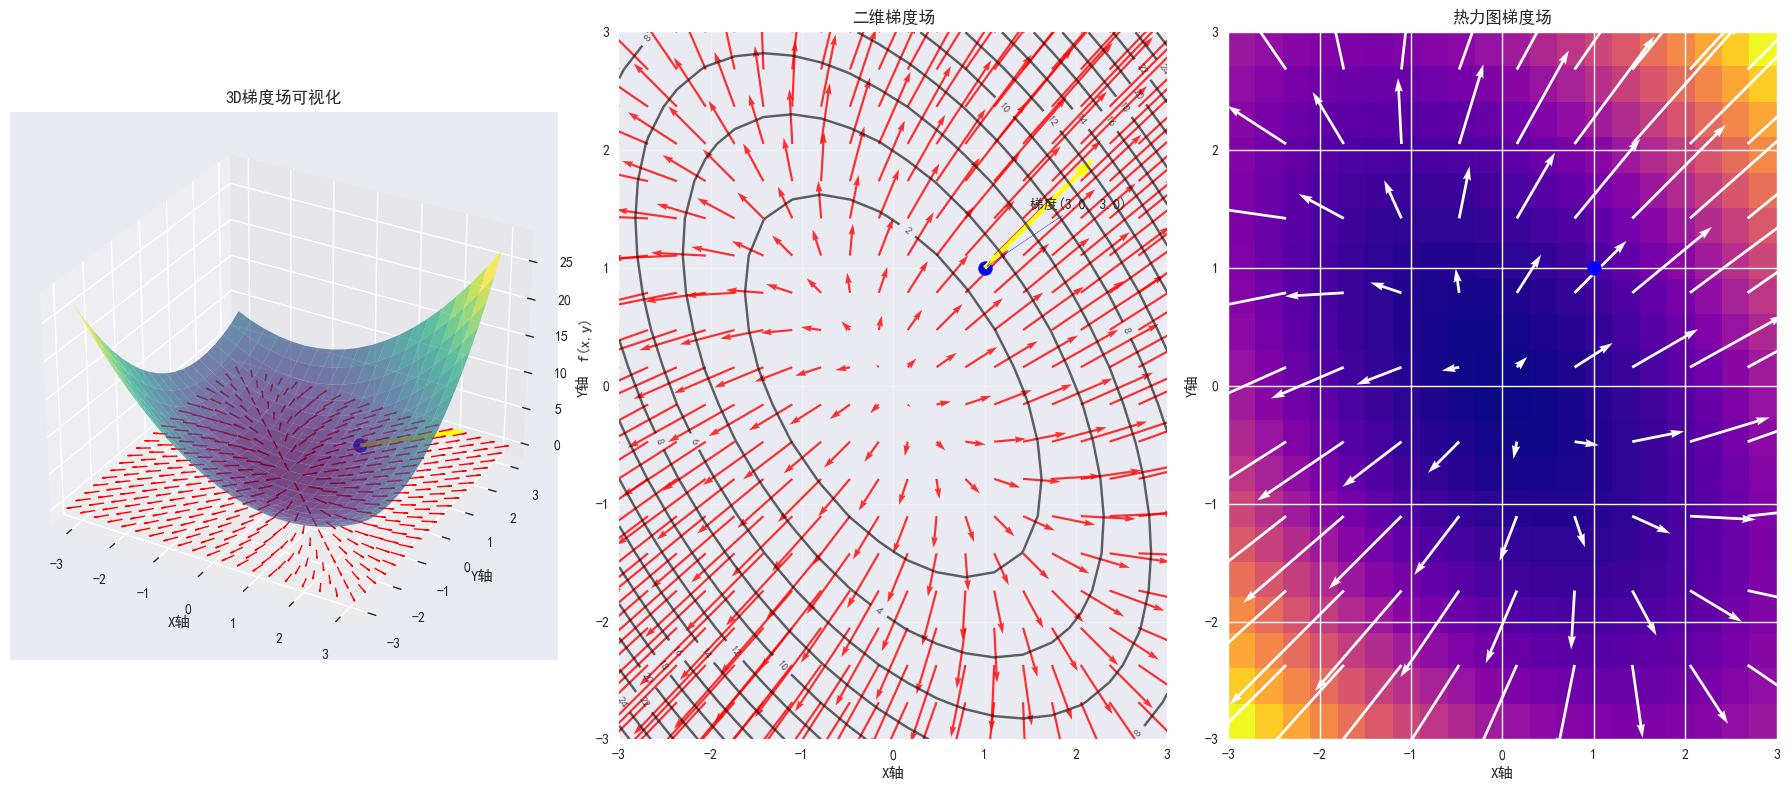

In [6]:
grad_x, grad_y = plot_gradient_field()

In [7]:
grad_x, grad_y

(3, 3)